Before I begin, catalog images with multiple products of different color have been removed.
1555 catalog images were fed into a darknet object detection neural net througe a unix environment
sourced darknet from: https://github.com/AlexeyAB/darknet
sbatch -o out.pillow_realjob -N 1 -n 1 -p gpu -t 07-00:00:00 --qos gpu_access --gres=gpu:1 --wrap 
"./darknet detector test ./cfg/openimages.data ./cfg/yolov3-openimages.cfg ../weights/yolov3-openimages.weights -thresh 0.05 -ext_output < ../Pillow_select_list > Pillow_select_results.txt"
detection threshold set to 0.05 to catch as many objects as possible

Note that the goal is not to accurately detect throw pillow, but to get location of any objects,
the reason being that the types of background objects in a catalog image are usually limited and expectted.
For example, here you would expect sofa, chair, window, flower, etc.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import compress
from ast import literal_eval
from PIL import Image
dir = os.getcwd()
home = os.path.dirname(os.path.dirname(dir)) ## 2 levels up of working directory dir

In [191]:
# path_input_image = r'Yolov3_pillow/Pillow_select_list'
# path_cropped_image = r'Yolov3_pillow/result_batch3/result_img'
# path_output_log = r'Yolov3_pillow/result_batch3/Pillow_select_results.txt'

def getbox (path_input_image, path_cropped_image, path_output_log):

    ##(part 1) 
    # use this format for all path: path = r'path/to/happiness'
    # import an index file that has the order in which the catalog images are detected on darknet.
    pd_index_darknet = pd.read_csv(os.path.join(home, path_input_image), sep = " ", header = None)
    pd_index_darknet.columns = ["image"]
    pd_index_darknet["dn_order"] = pd_index_darknet.index.values + 1
    
    t1 = [i[1] for i in pd_index_darknet['image'].apply(os.path.split)]
    pd_index_darknet['index_image'] = [os.path.splitext(i)[0] for i in t1]
    del t1
    
    ##(part 2) 
    # list of darknet output cropped images
    # these images named by dn_order (1 per input image), box id (sequential of all detected
    dn_crop = os.listdir(os.path.join(home, path_cropped_image))
    
    # for example, "img_184_379_465_Furniture.jpg.jpg": dn_order = 184, box_order =379, class id #465 for furniture
    class_name = [str(os.path.splitext(os.path.splitext(i)[0])[0]).split('_')[-1] for i in dn_crop]
    dn_order = [str(os.path.splitext(os.path.splitext(i)[0])[0]).split('_')[1] for i in dn_crop]
    box_order = [str(os.path.splitext(os.path.splitext(i)[0])[0]).split('_')[2] for i in dn_crop]
    class_id = [str(os.path.splitext(os.path.splitext(i)[0])[0]).split('_')[-2] for i in dn_crop]
    t1 = pd.DataFrame({"dn_crop": dn_crop,
                        "dn_order": list(map(int,dn_order)),
                        "box_order": list(map(int,box_order)),
                        "class_name": class_name,
                        "class_id": list(map(int,class_id))})
    crop = pd.merge(t1, pd_index_darknet, on='dn_order', how='left').sort_values(by=['box_order'])
    crop.index = crop['box_order']
    
    ##(part 3)
    # Next, import the detection log file to get coordinates for each bounding box
    # Bounding box (left_x, top_y, width, height)
    f=open(os.path.join(home, path_output_log), "r")
    if f.mode == 'r':
        log =f.readlines()
    #print("The log has " + str(len(log)) + " lines")

    # extract lines with box coordinates:
    log_w_box = list(compress(log, ["(" in i for i in log]))
    #print("Extracted " + str(len(log_w_box)) + " lines, each with a box coordinate.")

    # extract coordinates of bounding boxes
    box_coordinate = [i.split("(")[1].split(")")[0] for i in log_w_box]
   
    ##(part 4)
    # This is very annoying, but when darknet saved cropped images for a given input, 
    # the output image names are not following the same order as in log, despite what's claimed. 
    # Bounding boxes in the log was ordered by greatest prob% of detected objects in that bounding box.
    # So the plan is to get the size of cropped images and try to match up with the bounding box measurements.    
    folderpath = os.path.join(home, path_cropped_image)

    def getsize(image_name):
        with Image.open(os.path.join(folderpath,image_name)) as img:
            width, height = img.size
        return [width, height, width*height]

    size = [getsize(i) for i in dn_crop]

    pd_size = pd.DataFrame(size, columns=["crop_width","crop_height","crop_area"])
    pd_size ["dn_crop"] = dn_crop

    crop_mad = pd.merge(crop, pd_size, on='dn_crop', how='left').sort_values(by=['box_order'])

    def str_to_int(string):
        l = []
        for t in string.split():
            try:
                l.append(int(t))
            except ValueError:
                pass
        return l
    t2 = [str_to_int(i) for i in box_coordinate]
    t4 = pd.DataFrame.from_records(t2, columns=['left_x', 'top_y', 'width', 'height'])
    # t4 is the original order of bounding boxes from log file.
    # now add dn_order which indicates which croppe image this measurements refer to.
    t4['dn_order'] = crop["dn_order"].values.tolist()
    t4['box_area'] = np.array(t4['width']) * np.array(t4['height'])

    ##(part 4)
    # sort both t4 and crop_mad by dn_order and then box_area
    # then merge two
    t4_sorted = t4.sort_values(by=['dn_order','box_area']).reset_index(drop=True)
    crop_mad_sorted = crop_mad.sort_values(by=['dn_order','crop_area']).reset_index(drop=True) 

    crop_happy = crop_mad_sorted.join(t4_sorted.iloc[:,range(4)]).sort_values(by=['box_order']).reset_index(drop=True)
    
    return crop_happy

In [193]:
output = getbox(path_input_image = r'Yolov3_pillow/Pillow_select_list',
             path_cropped_image = r'Yolov3_pillow/result_batch3/result_img',
             path_output_log = r'Yolov3_pillow/result_batch3/Pillow_select_results.txt')
print(str(output.shape[0]) + " bounding boxes returned from detection.")
output.tail(5)

3021 bounding boxes returned from detection.


,dn_crop,dn_order,box_order,class_name,class_id,image,index_image,crop_width,crop_height,crop_area,left_x,top_y,width,height
3016,img_1553_3017_432_Clothing.jpg.jpg,1553,3017,Clothing,432,Pillow_select/Page_9_7.jpg,Page_9_7,409,353,144377,56,63,409,353
3017,img_1553_3018_465_Furniture.jpg.jpg,1553,3018,Furniture,465,Pillow_select/Page_9_7.jpg,Page_9_7,441,373,164493,22,54,441,372
3018,img_1554_3019_465_Furniture.jpg.jpg,1554,3019,Furniture,465,Pillow_select/Page_9_8.jpg,Page_9_8,406,311,126266,42,110,406,311
3019,img_1554_3020_432_Clothing.jpg.jpg,1554,3020,Clothing,432,Pillow_select/Page_9_8.jpg,Page_9_8,394,299,117806,61,116,394,299
3020,img_1555_3021_465_Furniture.jpg.jpg,1555,3021,Furniture,465,Pillow_select/Page_9_9.jpg,Page_9_9,398,372,148056,43,54,398,372


In [204]:
# assign two scores: a deviation score and a centerness score
# dev_score = d/sqrt(a); c_score = d 
# where d = distance between center of input image and center of box
# and a = area of box
def get_score (list):
    left_x = list[0]
    top_y = list[1]
    w = list[2]
    h = list[3]
    d = np.math.sqrt((left_x + w/2)**2+(top_y - h/2)**2)
    sr_area = np.math.sqrt(w * h)
    return [d/sr_area, d]

scores = output[['left_x','top_y','width','height']].apply(get_score, axis = 1)
output ['deviation-score'] = [i[0] for i in scores]
output ['centerness-score'] = [i[1] for i in scores]

In [206]:
output.tail(5)

,dn_crop,dn_order,box_order,class_name,class_id,image,index_image,crop_width,crop_height,crop_area,left_x,top_y,width,height,deviation-score,centerness-score
3016,img_1553_3017_432_Clothing.jpg.jpg,1553,3017,Clothing,432,Pillow_select/Page_9_7.jpg,Page_9_7,409,353,144377,56,63,409,353,0.747829,284.152248
3017,img_1553_3018_465_Furniture.jpg.jpg,1553,3018,Furniture,465,Pillow_select/Page_9_7.jpg,Page_9_7,441,373,164493,22,54,441,372,0.681668,276.098261
3018,img_1554_3019_465_Furniture.jpg.jpg,1554,3019,Furniture,465,Pillow_select/Page_9_8.jpg,Page_9_8,406,311,126266,42,110,406,311,0.701271,249.189185
3019,img_1554_3020_432_Clothing.jpg.jpg,1554,3020,Clothing,432,Pillow_select/Page_9_8.jpg,Page_9_8,394,299,117806,61,116,394,299,0.757995,260.165813
3020,img_1555_3021_465_Furniture.jpg.jpg,1555,3021,Furniture,465,Pillow_select/Page_9_9.jpg,Page_9_9,398,372,148056,43,54,398,372,0.716406,275.659210


Ok. Stop here. Below are scraches.

In [2]:
# import an index file that has the order in which the catalog images are detected on darknet.
pd_index_darknet = pd.read_csv(os.path.join(home, r'Yolov3_pillow/Pillow_select_list'), sep = " ", header = None)
pd_index_darknet.columns = ["image"]
pd_index_darknet["dn_order"] = pd_index_darknet.index.values + 1

t1 = [i[1] for i in pd_index_darknet['image'].apply(os.path.split)]
pd_index_darknet['index_image'] = [os.path.splitext(i)[0] for i in t1]
del t1

In [3]:
print(pd_index_darknet.head())

                          image  dn_order index_image
0  Pillow_select/Page_10_11.jpg         1  Page_10_11
1  Pillow_select/Page_10_12.jpg         2  Page_10_12
2  Pillow_select/Page_10_13.jpg         3  Page_10_13
3  Pillow_select/Page_10_14.jpg         4  Page_10_14
4  Pillow_select/Page_10_15.jpg         5  Page_10_15


In [15]:
# list of darknet output cropped images
# these images named by dn_order (1 per input image), box id (sequential of all detected objects) and class id & name.
dn_crop = os.listdir(os.path.join(home, r'Yolov3_pillow/result_batch3/result_img'))

In [124]:
# for example, "img_184_379_465_Furniture.jpg.jpg": dn_order = 184, box_order =379, class id #465 for furniture
class_name = [str(os.path.splitext(os.path.splitext(i)[0])[0]).split('_')[-1] for i in dn_crop]
dn_order = [str(os.path.splitext(os.path.splitext(i)[0])[0]).split('_')[1] for i in dn_crop]
box_order = [str(os.path.splitext(os.path.splitext(i)[0])[0]).split('_')[2] for i in dn_crop]
class_id = [str(os.path.splitext(os.path.splitext(i)[0])[0]).split('_')[-2] for i in dn_crop]
t1 = pd.DataFrame({"dn_crop": dn_crop,
                    "dn_order": list(map(int,dn_order)),
                    "box_order": list(map(int,box_order)),
                    "class_name": class_name,
                    "class_id": list(map(int,class_id))})
crop = pd.merge(t1, pd_index_darknet, on='dn_order', how='left').sort_values(by=['box_order'])
crop.index = crop['box_order']

print("Detected " + str(max(crop['box_order'])) 
      +" bounding boxes from " + str(len(list(Counter(dn_order).keys())))
      + " out of the 1555 images.")
crop.head()

Detected 3021 bounding boxes from 1534 out of the 1555 images.


,dn_crop,dn_order,box_order,class_name,class_id,image,index_image
box_order,,,,,,,
1,img_1_1_192_Food.jpg.jpg,1,1,Food,192,Pillow_select/Page_10_11.jpg,Page_10_11
2,img_2_2_333_Plant.jpg.jpg,2,2,Plant,333,Pillow_select/Page_10_12.jpg,Page_10_12
3,img_2_3_192_Food.jpg.jpg,2,3,Food,192,Pillow_select/Page_10_12.jpg,Page_10_12
4,img_2_4_432_Clothing.jpg.jpg,2,4,Clothing,432,Pillow_select/Page_10_12.jpg,Page_10_12
5,img_3_5_365_Picture frame.jpg.jpg,3,5,Picture frame,365,Pillow_select/Page_10_13.jpg,Page_10_13


In [7]:
#counter=Counter(crop['class_name'])
#test=[list(counter.keys()),list(counter.values())]
#pd.DataFrame(np.array(test).T, columns=['class_name','Count'])
#plt.hist(crop["class_id"],bins=100)

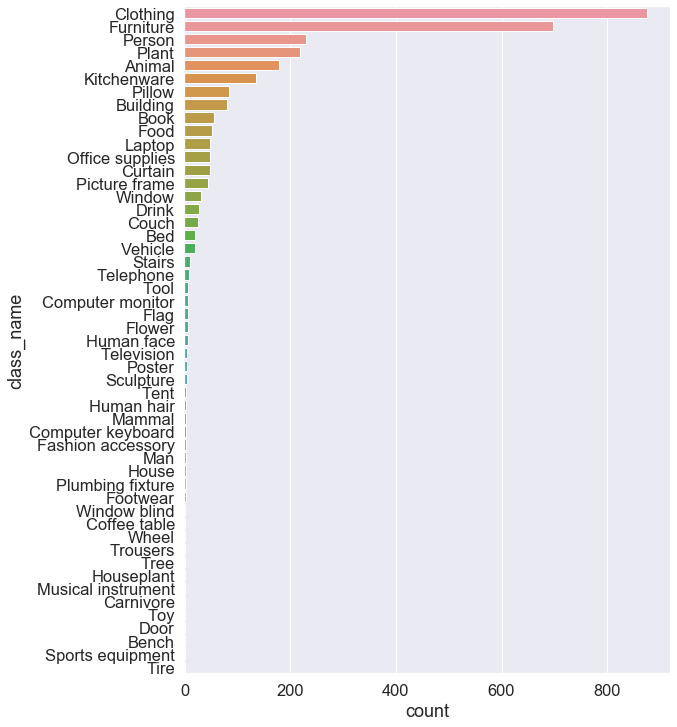

In [74]:
sns.set(font_scale=1)
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(8.7,12.27)})
sns.set_context("notebook", font_scale=1.5)
ax = sns.countplot(y="class_name", 
                   data=crop,
                   order = crop["class_name"].value_counts().index)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

In [167]:
# This is very annoying, but when darknet saved cropped images for a given input, 
# the output image names are not following the same order as in log, despite what's claimed. 
# Bounding boxes in the log was ordered by greatest prob% of detected objects in that bounding box.
# So the plan is to get the size of cropped images and try to match up with the bounding box measurements.
from PIL import Image
path = r'Yolov3_pillow/result_batch3/result_img'
folderpath = os.path.join(home, path)
dn_crop = os.listdir(folderpath) #this is the list of image names

def getsize(image_name):
    with Image.open(os.path.join(folderpath,image_name)) as img:
        width, height = img.size
    return [width, height, width*height]

size = [getsize(i) for i in dn_crop]

pd_size = pd.DataFrame(size, columns=["crop_width","crop_height","crop_area"])
pd_size ["dn_crop"] = dn_crop

crop_mad = pd.merge(crop, pd_size, on='dn_crop', how='left').sort_values(by=['box_order'])

def str_to_int(string):
    l = []
    for t in string.split():
        try:
            l.append(int(t))
        except ValueError:
            pass
    return l
t2 = [str_to_int(i) for i in box_coordinate]
t4 = pd.DataFrame.from_records(t2, columns=['left_x', 'top_y', 'width', 'height'])
# t4 is the original order of bounding boxes from log file.
# now add dn_order which indicates which croppe image this measurements refer to.
t4['dn_order'] = crop["dn_order"].values.tolist()
t4['box_area'] = np.array(t4['width']) * np.array(t4['height'])

# sort both t4 and crop_mad by dn_order and then box_area
# then merge two
t4_sorted = t4.sort_values(by=['dn_order','box_area']).reset_index(drop=True)
crop_mad_sorted = crop_mad.sort_values(by=['dn_order','crop_area']).reset_index(drop=True) 

crop_happy = crop_mad_sorted.join(t4_sorted.iloc[:,range(4)]).sort_values(by=['box_order']).reset_index(drop=True)

In [170]:
pd_size.tail()

,crop_width,crop_height,crop_area,dn_crop
3016,452,288,130176,img_1300_2523_432_Clothing.jpg.jpg
3017,467,445,207815,img_1398_2716_432_Clothing.jpg.jpg
3018,479,377,180583,img_1385_2694_465_Furniture.jpg.jpg
3019,479,478,228962,img_717_1410_264_Kitchenware.jpg.jpg
3020,89,361,32129,img_1434_2792_333_Plant.jpg.jpg


In [172]:
crop_mad.tail()

,dn_crop,dn_order,box_order,class_name,class_id,image,index_image,crop_width,crop_height,crop_area
3016,img_1553_3017_432_Clothing.jpg.jpg,1553,3017,Clothing,432,Pillow_select/Page_9_7.jpg,Page_9_7,409,353,144377
3017,img_1553_3018_465_Furniture.jpg.jpg,1553,3018,Furniture,465,Pillow_select/Page_9_7.jpg,Page_9_7,441,373,164493
3018,img_1554_3019_465_Furniture.jpg.jpg,1554,3019,Furniture,465,Pillow_select/Page_9_8.jpg,Page_9_8,406,311,126266
3019,img_1554_3020_432_Clothing.jpg.jpg,1554,3020,Clothing,432,Pillow_select/Page_9_8.jpg,Page_9_8,394,299,117806
3020,img_1555_3021_465_Furniture.jpg.jpg,1555,3021,Furniture,465,Pillow_select/Page_9_9.jpg,Page_9_9,398,372,148056


In [174]:
def str_to_int(string):
    l = []
    for t in string.split():
        try:
            l.append(int(t))
        except ValueError:
            pass
    return l
t2 = [str_to_int(i) for i in box_coordinate]
t4 = pd.DataFrame.from_records(t2, columns=['left_x', 'top_y', 'width', 'height'])
# t4 is the original order of bounding boxes from log file.
# now add dn_order which indicates which croppe image this measurements refer to.
t4['dn_order'] = crop["dn_order"].values.tolist()
t4['box_area'] = np.array(t4['width']) * np.array(t4['height'])

In [175]:
t4.tail()

,left_x,top_y,width,height,dn_order,box_area
3016,22,54,441,372,1553,164052
3017,56,63,409,353,1553,144377
3018,42,110,406,311,1554,126266
3019,61,116,394,299,1554,117806
3020,43,54,398,372,1555,148056


In [185]:
# sort both t4 and crop_mad by dn_order and then box_area
# then merge two
t4_sorted = t4.sort_values(by=['dn_order','box_area']).reset_index(drop=True)
crop_mad_sorted = crop_mad.sort_values(by=['dn_order','crop_area']).reset_index(drop=True) 


In [186]:
crop_mad_sorted.head(10)

,dn_crop,dn_order,box_order,class_name,class_id,image,index_image,crop_width,crop_height,crop_area
0,img_1_1_192_Food.jpg.jpg,1,1,Food,192,Pillow_select/Page_10_11.jpg,Page_10_11,405,381,154305
1,img_2_2_333_Plant.jpg.jpg,2,2,Plant,333,Pillow_select/Page_10_12.jpg,Page_10_12,377,419,157963
2,img_2_4_432_Clothing.jpg.jpg,2,4,Clothing,432,Pillow_select/Page_10_12.jpg,Page_10_12,374,443,165682
3,img_2_3_192_Food.jpg.jpg,2,3,Food,192,Pillow_select/Page_10_12.jpg,Page_10_12,409,417,170553
4,img_3_5_365_Picture frame.jpg.jpg,3,5,Picture frame,365,Pillow_select/Page_10_13.jpg,Page_10_13,414,443,183402
5,img_4_7_432_Clothing.jpg.jpg,4,7,Clothing,432,Pillow_select/Page_10_14.jpg,Page_10_14,468,238,111384
6,img_4_6_465_Furniture.jpg.jpg,4,6,Furniture,465,Pillow_select/Page_10_14.jpg,Page_10_14,477,273,130221
7,img_5_8_264_Kitchenware.jpg.jpg,5,8,Kitchenware,264,Pillow_select/Page_10_15.jpg,Page_10_15,468,452,211536
8,img_5_9_446_Book.jpg.jpg,5,9,Book,446,Pillow_select/Page_10_15.jpg,Page_10_15,462,459,212058
9,img_6_10_432_Clothing.jpg.jpg,6,10,Clothing,432,Pillow_select/Page_10_16.jpg,Page_10_16,463,338,156494


In [187]:
t4_sorted.head(10)

,left_x,top_y,width,height,dn_order,box_area
0,39,48,404,381,1,153924
1,33,12,376,419,2,157544
2,33,14,374,443,2,165682
3,34,13,409,417,2,170553
4,34,19,414,443,3,183402
5,5,123,469,238,4,111622
6,-5,122,482,274,4,132068
7,10,9,462,459,5,212058
8,5,28,468,459,5,214812
9,7,70,463,338,6,156494


In [190]:
crop_happy = crop_mad_sorted.join(t4_sorted.iloc[:,range(4)]).sort_values(by=['box_order']).reset_index(drop=True)
crop_happy.head()

,dn_crop,dn_order,box_order,class_name,class_id,image,index_image,crop_width,crop_height,crop_area,left_x,top_y,width,height
0,img_1_1_192_Food.jpg.jpg,1,1,Food,192,Pillow_select/Page_10_11.jpg,Page_10_11,405,381,154305,39,48,404,381
1,img_2_2_333_Plant.jpg.jpg,2,2,Plant,333,Pillow_select/Page_10_12.jpg,Page_10_12,377,419,157963,33,12,376,419
2,img_2_3_192_Food.jpg.jpg,2,3,Food,192,Pillow_select/Page_10_12.jpg,Page_10_12,409,417,170553,34,13,409,417
3,img_2_4_432_Clothing.jpg.jpg,2,4,Clothing,432,Pillow_select/Page_10_12.jpg,Page_10_12,374,443,165682,33,14,374,443
4,img_3_5_365_Picture frame.jpg.jpg,3,5,Picture frame,365,Pillow_select/Page_10_13.jpg,Page_10_13,414,443,183402,34,19,414,443


In [207]:
output[output['dn_order']==11]

,dn_crop,dn_order,box_order,class_name,class_id,image,index_image,crop_width,crop_height,crop_area,left_x,top_y,width,height,deviation-score,centerness-score
15,img_11_16_333_Plant.jpg.jpg,11,16,Plant,333,Pillow_select/Page_10_22.jpg,Page_10_22,173,176,30448,307,-1,181,178,2.270616,407.561345
16,img_11_17_465_Furniture.jpg.jpg,11,17,Furniture,465,Pillow_select/Page_10_22.jpg,Page_10_22,299,124,37076,18,355,300,129,1.705851,335.580467
17,img_11_18_333_Plant.jpg.jpg,11,18,Plant,333,Pillow_select/Page_10_22.jpg,Page_10_22,162,64,10368,315,2,162,63,3.930693,397.097280
18,img_11_19_264_Kitchenware.jpg.jpg,11,19,Kitchenware,264,Pillow_select/Page_10_22.jpg,Page_10_22,80,82,6560,132,335,79,81,4.260294,340.796860
19,img_11_20_465_Furniture.jpg.jpg,11,20,Furniture,465,Pillow_select/Page_10_22.jpg,Page_10_22,459,276,126684,10,76,459,276,0.695072,247.394927
